# Notebook III: Prediction

This notebook is about final prediction of instances (buildings) from satellite images. Here results from centroid estimation and instance segmentation CNNs will be combined producing final results.

__Content of this notebook:__

    1) Reading and Exploring Data
    2) Importing Trained Models in Notebook I and II and Prediction
    3) Combining Results from Centroids Estimation and Instance Segmenting CNNs
    
__Dataset citation__: *SpaceNet on Amazon Web Services (AWS). “Datasets.” The SpaceNet Catalog. Last modified October 1st, 2018. https://spacenet.ai/datasets/*

The overall work flow of the prediction (inference) process explained in this notebook is as below,

<img src="./graphics/PredictWorkflow.PNG" alt="PredictWorkflow" width="70%"/>

<hr>
<hr>
<hr>

In [20]:
'''first importing libraries'''

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Lambda, Dropout, Dense
from keras import backend as K
from keras.models import model_from_json

import cv2

import glob
from random import shuffle
import numpy as np
from matplotlib import pyplot as plt
import random
import imageio

import tensorflow as tf

### 1) Reading and Exploring Data

In [21]:
'''Loading satellite images of test datasets'''

x_read = np.load('./data/tiles_satellite_images.npz')

x_test = x_read['x_test'].astype(float)
print(x_test.shape) # shape corresponding to: [Image tiles, Height, Width, R/G/B]

(648, 256, 256, 3)


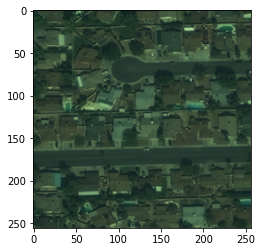

In [22]:
'''plotting  a sample image'''

plt.imshow(x_test[25,:,:,0:3])
plt.show()

### 2) Importing Trained Models in Notebook I and II and Prediction

In [23]:
'''importing trained models in Notebook I and II '''

# this is centroid estimation CNN model from Notebook I
json_file = open('./models/Centroid_Estimation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ctr = model_from_json(loaded_model_json)
model_ctr.load_weights("./models/Centroid_Estimation.h5")

# this is instance segmenting CNN model (only encoder section) from Notebook II
json_file = open('./models/InsSeg_Encoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ins = model_from_json(loaded_model_json)
model_ins.load_weights("./models/InsSeg_Encoder.h5")

(648, 32, 32, 257)
(648, 32, 32, 1)


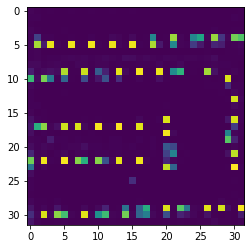

In [24]:
'''prediction from trained models over the test dataset'''

y_pred_ins = model_ins.predict(x_test, batch_size=10)
y_pred_ctr = model_ctr.predict(x_test, batch_size=50)

print(y_pred_ins.shape) # printing predicted output's shape
print(y_pred_ctr.shape) # printing predicted output's shape

# plotting a sample centroid estimation to test
plt.imshow(y_pred_ctr[8,:,:,0]) 
plt.show()

### 3) Combining Results from Centroids Estimation and Instance Segmenting CNNs

In [25]:
'''defining function for sigmoid'''

def sigmoid(x):
  return (1 / (1 + np.exp(-x)))

In [26]:
'''defining vanilla neural network (MLP) of Vec2Instance with python numpy library'''
'''here, we are writing decoder part of instance segmenting CNN (Notebook II) with python numpy library'''

im_height_big = im_width_big = 256 # height and width of satellite tiles
img_dim = 64 # image patch size 
out_var = 1 # output bands (single band for mask)
hidden_size = 64 # hidden size of vanilla neural network of Vec2Instace

def decorder2DNumpy(arg_in):
    
    # creating input of vanilla neural network (x and y coordinates)
    xx, yy = np.meshgrid(np.arange(-img_dim/2, img_dim/2), np.arange(-img_dim/2, img_dim/2))
    xx = xx.flatten()
    yy = yy.flatten()
    lyr_in = np.stack((xx, yy), axis=1)
    
    # vanilla neural network (MLP) of Vec2Instance
    lyr_hidden_wgt = np.stack( (arg_in[0:hidden_size], arg_in[hidden_size*1:hidden_size*2]), axis=1)
    lyr_hidden_b = np.matmul(np.ones((img_dim*img_dim,1)), np.reshape(arg_in[hidden_size*2:hidden_size*3],(1,hidden_size)) )
    lyr_hidden_out = np.tanh( np.matmul(lyr_in, lyr_hidden_wgt.T) +  lyr_hidden_b) 
    
    lyr_out_wgt = np.reshape( arg_in[hidden_size*3:hidden_size*(3+out_var)], (hidden_size,out_var))
    lyr_out_b = np.matmul(np.ones((img_dim*img_dim,1)), np.reshape(arg_in[hidden_size*(3+out_var):hidden_size*(3+out_var)+out_var], (1,out_var)) )
    lyr_out = sigmoid( np.matmul(lyr_hidden_out, lyr_out_wgt) + lyr_out_b ) 
    
    lyr_out_img = np.reshape( lyr_out, (img_dim,img_dim,out_var))
    
    return lyr_out_img[:,:,0]

print(decorder2DNumpy(y_pred_ins[10,10,10,:]).shape) # testing function

(64, 64)


In [27]:
'''defining function for non-max suppression of instances'''

def non_max_supression(im_ins_list):
    
    im_ins_list_pop = []
    
    for i3 in range(len(im_ins_list)):
        
        for i4 in range(len(im_ins_list)):
            
            if i3 == i4:
                continue
            
            pix_inter = np.logical_and(im_ins_list[i3]==1, im_ins_list[i4]==1).sum()
            pix_union = np.logical_or(im_ins_list[i3]==1, im_ins_list[i4]==1).sum()
            
            pix_iou = pix_inter/pix_union # intersection over union
            
            if (pix_iou>=0.2) and (y_pred_ctr[i1,ctr_X[i3],ctr_Y[i3],0]<=y_pred_ctr[i1,ctr_X[i4],ctr_Y[i4],0]):
                im_ins_list_pop.append(i4)
                break
    
    return im_ins_list_pop

In [28]:
'''final prediction (inference) over the test dataset'''

im_ins_seg_all_clr = np.zeros((x_test.shape[0],im_height_big, im_width_big)) # final results will be stored here

for i1 in range(x_test.shape[0]): # going through each image in the test dataset
        
    ctr_X,ctr_Y = np.where(y_pred_ctr[i1,:,:,0]>0.5) # getting predicted centroid locations
    
    im_ins_list = []

    for i2 in range(len(ctr_X)): # going through each predicted centroid locations
        
        # generating instance (building) from estimated vector from instance segmenting CNN at centroid location
        ins_seg = decorder2DNumpy(y_pred_ins[i1,ctr_X[i2],ctr_Y[i2],:])
        
        # handling instances at edges and copying instance image patches of shape of (64,64) pixels to original satellite image size of (256,256) pixels
        im_ins_temp = np.zeros((im_height_big+img_dim, im_width_big+img_dim))
        ins_seg_y0 = (ctr_Y[i2]*8)+32 - 32
        ins_seg_x0 = (ctr_X[i2]*8)+32 - 32
        ins_seg_y1 = (ctr_Y[i2]*8)+32 + 32
        ins_seg_x1 = (ctr_X[i2]*8)+32 + 32     
        im_ins_temp[ins_seg_x0:ins_seg_x1,ins_seg_y0:ins_seg_y1] = ins_seg>0.5 # thresholding to extract binary mask
        im_ins_temp = im_ins_temp[32:32+im_height_big, 32:32+im_width_big]
        
        im_ins_list.append( im_ins_temp ) # creating a list for non max suppression
    
    # performing non max suppression
    im_ins_list_pop = non_max_supression(im_ins_list)
    
    ins_lbl_random = np.arange(50,255,10) # this is to add random colors to predicted instances
    
    for i5 in range(len(im_ins_list)): # going through each predicted insurance (building) and adding random color
        if i5 not in im_ins_list_pop:
            # just to image new building area zero to replace it with new building
            im_ins_seg_all_clr[i1,:,:] = np.multiply(im_ins_seg_all_clr[i1,:,:], np.logical_not(im_ins_list[i5]))
            im_ins_seg_all_clr[i1,:,:] = im_ins_seg_all_clr[i1,:,:] + im_ins_list[i5]*np.random.choice(ins_lbl_random)

Prediction (inference) process is summarized here,
* In instance segmenting CNN (Notebook II), 256x256x3 input image goes through backbone CNN, outputting 32x32x257 tensor.
* Then, non-centroid points were masked out. These centroid points are estimated by centroid estimation CNN (Notebook I) at 32x32 image size/scale.
* Then, 257 element vectors at each instance centroid is re-arranged as weights and biases of vanilla neural network (MLP) in __*decorder2DNumpy*__ function here (Notebook III).
* This vanilla neural network (MLP) applied on pixel coordinates centered at the centroid of each instance outputting instance mask (value is 1 within the mask and value is 0 outside the mask) for each instance (__*decorder2DNumpy*__ function here).
* Finally non-max suppression is applied to get rid of instances with large overlapping area. (Here output of centroid estimation for each instance which is a value between 0 and 1 indicates confidence of estimation for each instance).

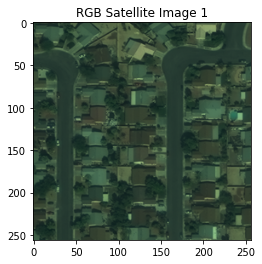

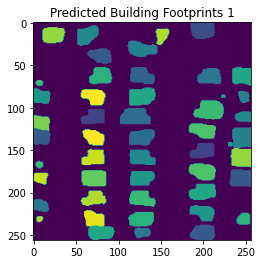

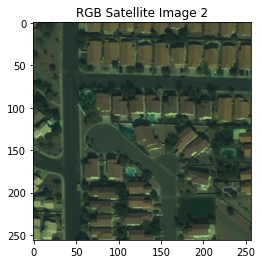

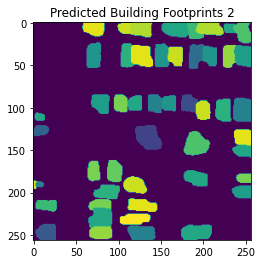

In [41]:
'''plot couple of predictions to see how it comes'''

rand_idx = np.random.randint(0,x_test.shape[0]) # generation random index to choose random sample

plt.imshow(x_test[rand_idx,:,:,:])
plt.title('RGB Satellite Image 1')
plt.show()
plt.imshow(im_ins_seg_all_clr[rand_idx,:,:])
plt.title('Predicted Building Footprints 1')
plt.show()

rand_idx = np.random.randint(0,x_test.shape[0]) # generation random index to choose random sample

plt.imshow(x_test[rand_idx,:,:,:])
plt.title('RGB Satellite Image 2')
plt.show()
plt.imshow(im_ins_seg_all_clr[rand_idx,:,:])
plt.title('Predicted Building Footprints 2')
plt.show()